In [1]:
import numpy as np
import matplotlib.pyplot as plt

# gpie-ptychography
from ptychography.preprocessing import preprocess_diffraction_data
from examples.generate_synthetic_data import generate_synthetic_dataset

# gPIE runner
from algorithm.gpie.runner import (
    GPiePtychographyRunner,
    GPieRunConfig,
)

In [2]:
# ------------------------------------------------------------
# Generate synthetic ptychography dataset
# ------------------------------------------------------------

ctx, probe_true, object_true, diffraction_data = generate_synthetic_dataset(
    n_scan=49,
    object_shape=(256, 256),
    probe_shape=(128, 128),
    photon_scale=10000.0,
    rng_seed=20,
)

print(f"n_scan = {len(diffraction_data)}")

n_scan = 49


C:\Users\ndhaj\Desktop\gpie-ptychography\ptychography\optics\aperture.py:52: RuntimeWarning: divide by zero encountered in divide
  mask = xp().exp(-0.5 * ((R - aperture_radius) / sigma) ** 2)


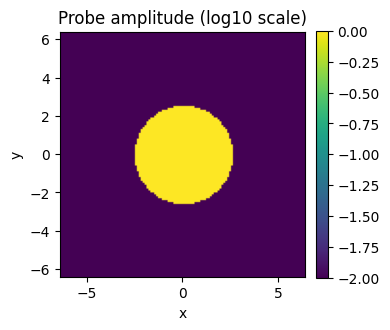

In [3]:
# ------------------------------------------------------------
# Probe amplitude with real-space scale
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))

amp = np.abs(probe_true)
log_amp = np.log10(amp + 1e-6)

ny, nx = probe_true.shape
pixel_pitch = ctx.pixel_pitch

# Define real-space extent (centered at zero)
extent = (
    -0.5 * nx * pixel_pitch,
     0.5 * nx * pixel_pitch,
    -0.5 * ny * pixel_pitch,
     0.5 * ny * pixel_pitch,
)

im = ax.imshow(
    log_amp,
    cmap="viridis",
    vmin=-2.0,
    vmax=0.0,
    extent=extent,
)

ax.set_title("Probe amplitude (log10 scale)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal", adjustable="box")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()

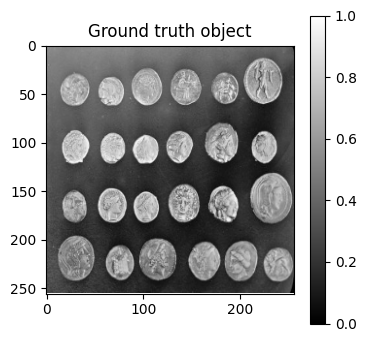

In [4]:
plt.figure(figsize=(4, 4))
plt.imshow(object_true, cmap="gray")
plt.title("Ground truth object")
plt.colorbar()
plt.show()

In [5]:
# ------------------------------------------------------------
# Preprocess diffraction data
# ------------------------------------------------------------

dataset = preprocess_diffraction_data(
    diffraction_data,
    object_shape=ctx.object_shape,
)

In [6]:
# ------------------------------------------------------------
# Initial object guess
# ------------------------------------------------------------

init_object = np.ones(ctx.object_shape, dtype=np.complex64)

In [7]:
# ------------------------------------------------------------
# Build gPIE runner (known probe)
# ------------------------------------------------------------

runner = GPiePtychographyRunner(
    dataset,
    known_probe=True,
    probe=probe_true,
    backend="numpy",
    damping="auto",
)

#runner.set_object_init("manual", init_object)
runner.set_init_rng(seed=42)

C:\Users\ndhaj\Desktop\gpie\gpie\graph\measurement\base.py:151: UserWarning: Observed dtype float64 does not exactly match expected dtype <class 'numpy.float32'>. Automatic casting will be applied.
  warnings.warn(


In [8]:
# ------------------------------------------------------------
# Run reconstruction
# ------------------------------------------------------------

config = GPieRunConfig(
    n_iter=200,
    schedule="sequential",
    verbose=True,
)

fitness_history = []

def callback(iteration, metrics):
    fitness_history.append(metrics["fitness"])

runner.run(config, callback=callback)

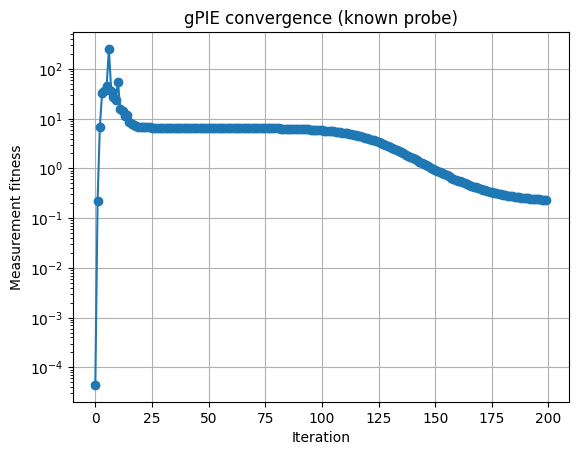

In [9]:
plt.figure()
plt.plot(fitness_history, "-o")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Measurement fitness")
plt.title("gPIE convergence (known probe)")
plt.grid(True)
plt.show()

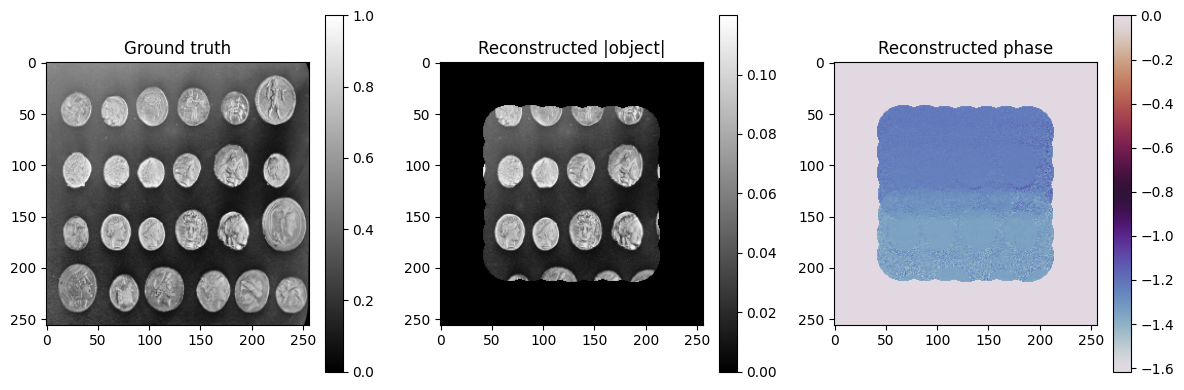

In [10]:
recon_object = runner.get_object()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(object_true, cmap="gray")
plt.title("Ground truth")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.abs(recon_object), cmap="gray")
plt.title("Reconstructed |object|")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.angle(recon_object), cmap="twilight")
plt.title("Reconstructed phase")
plt.colorbar()

plt.tight_layout()
plt.show()